In [208]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [209]:
%matplotlib inline

In [210]:
from   som                   import train_SOM, distSq, find_BMU, update_weights
import numpy             as np
import matplotlib.pyplot as plt
import os
import sys
from   astropy.table       import Table, join, unique
from   sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
import pandas            as pd
import seaborn           as sns
from scipy.stats import norm

In [211]:
# Dimensions of the SOM grid
m   = 10
n   = 10

# Number of training examples
n_x = 3000

In [212]:
rand = np.random.RandomState(0)

In [213]:
sys.path.append(os.environ['HOME'])
sys.path.append(os.environ['HOME'] + '/DESI/')

In [214]:
photoz = Table.read('/cosma/home/durham/dc-bigw1/data/EAZYPhotoZv02.fits')

In [215]:
#load science catalog w spectroscopic zs 

sci = Table.read('/cosma/home/durham/dc-bigw1/data/gkvScienceCatv02.fits')
sci = sci[sci['SC'] >= 7] # r_KIDS < 19.65
sci = sci[sci['NQ'] >= 3]
sci = sci[sci['mag'] <= 19.5]
sci = sci[(sci['Z']< 0.263)]
sci.sort('uberID')
sci

uberID,RAcen,Deccen,RAmax,Decmax,RAGAIA,DecGAIA,sky_mean,skyRMS_mean,log10seeing,EBV,mag,R50,R90,R100,N100,axrat,ang,flux_FUVt,flux_FUVl,flux_err_FUVt,flux_NUVt,flux_NUVl,flux_err_NUVt,flux_ut,flux_ul,flux_err_ut,flux_gt,flux_gl,flux_err_gt,flux_rt,flux_rl,flux_err_rt,flux_it,flux_il,flux_err_it,flux_Zt,flux_Zl,flux_err_Zt,flux_Yt,flux_Yl,flux_err_Yt,flux_Jt,flux_Jl,flux_err_Jt,flux_Ht,flux_Hl,flux_err_Ht,flux_Kt,flux_Kl,flux_err_Kt,flux_W1t,flux_W1l,flux_err_W1t,flux_W2t,flux_W2l,flux_err_W2t,duplicate,mask,starmask,uberclass,CATAID,SC,Z,NQ
,deg,deg,deg,deg,deg,deg,Jy,Jy,log(arcsec),mag,mag,arcsec,arcsec,arcsec,,,deg,Jy,Jy,Jy,Jy,Jy,Jy,Jy,Jy,Jy,Jy,Jy,Jy,Jy,Jy,Jy,Jy,Jy,Jy,Jy,Jy,Jy,Jy,Jy,Jy,Jy,Jy,Jy,Jy,Jy,Jy,Jy,Jy,Jy,Jy,Jy,Jy,Jy,Jy,Jy,,,,,,,,
int64,float64,float64,float64,float64,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,int32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,bool,bool,bool,int16,int32,int16,float32,int16
128980003711188,129.579930278292,-1.02978043903405,129.579932683367,-1.02978364542057,129.579917127811,-1.0298019787539,-3.2522729e-13,3.9659894e-12,-0.25130096,0.039404288,17.2534,2.0644488,5.534397,12.665411,2359,0.5379462,14.949414,3.7622426e-06,1.8775262e-06,6.592376e-08,1.8948501e-06,4.639499e-07,1.783146e-07,3.1354277e-05,2.9739422e-05,2.3111963e-06,0.00017459311,0.00017035949,8.010887e-07,0.0004252589,0.00041564586,9.38886e-07,0.00063660165,0.0006154055,4.277399e-06,0.0008387682,0.00080726604,2.8500554e-06,0.0010912559,0.0010391885,4.318675e-06,0.0012729218,0.0012607822,6.7473425e-06,0.0016559247,0.0015765553,1.0185171e-05,0.0014912887,0.0014136028,1.1099676e-05,0.00076479634,0.0006932739,4.308207e-06,0.00041533215,0.00038133233,9.162291e-06,False,False,False,1,3600151,8,0.08185,4
128980017205121,129.56735542411502,-1.60105099145147,129.567367933367,-1.60105643419209,129.567352377812,-1.60107476752542,-1.1061156e-12,4.1897644e-12,-0.25130096,0.036009856,17.78686,1.3036978,3.7962666,7.5803733,1472,0.93707883,126.88247,1.2472456e-05,-2.16377e-06,1.4185689e-08,2.740973e-06,2.144995e-06,2.3692742e-07,2.8958755e-05,2.6454809e-05,1.4469474e-06,0.0001315551,0.00012996743,5.6003586e-07,0.00027199896,0.00026531736,1.0579317e-06,0.00037143225,0.00036527848,1.344785e-06,0.0004790828,0.00046231222,2.5020165e-06,0.0005745195,0.0005641217,5.227442e-06,0.0006510799,0.00064691936,1.0659784e-05,0.0008752744,0.00082399807,1.7772747e-05,0.00072609313,0.00067566667,1.5473352e-05,0.00027427723,0.0002669144,2.3332882e-06,0.00021868071,0.00020716382,2.971003e-06,False,False,False,1,3576027,8,0.07561,4
128980021408151,129.563301477484,-1.31574396043543,129.563338320765,-1.3157470574238002,129.563322765209,-1.3157653907571398,-8.240433e-13,4.219561e-12,-0.25130096,0.036053397,19.222736,1.9400676,3.714947,6.099009,741,0.7287007,176.39502,6.6191105e-06,2.0462307e-06,3.2770096e-08,8.735094e-06,7.9577485e-06,1.713405e-07,1.7805967e-05,1.5461315e-05,9.2396283e-07,4.1789903e-05,4.0562e-05,3.755037e-07,7.624874e-05,7.465981e-05,5.068146e-07,8.782237e-05,9.335687e-05,9.09539e-07,0.00010838744,0.00010490628,1.1827308e-06,0.0001268699,0.00011988247,2.7707044e-06,0.00012712347,0.000120388075,4.2731212e-06,0.00013966882,0.00012902652,7.4451877e-06,0.00018381464,0.00017088781,8.097983e-06,5.5529632e-05,4.569066e-05,5.823822e-07,6.685675e-05,7.093226e-05,2.161309e-06,False,False,False,1,3874415,8,0.20977,4
128980023507290,129.561379633397,-1.3967777187698,129.561381298784,-1.39682058790899,129.561365743228,-1.39683892124232,-6.68756e-13,4.0972854e-12,-0.25130096,0.034831997,18.523563,1.8815932,3.9887981,6.948497,965,0.7311309,27.249044,1.3383186e-05,7.2427797e-06,4.8676e-09,1.8144572e-05,1.0270954e-05,2.721286e-07,3.3008735e-05,3.00

In [216]:
#join with catalog with photometric redshifts

sci = join(sci, photoz, join_type='left', keys='uberID')

In [217]:
#box of science catalogue

isin  = (sci['Deccen'] > -2.0)
isin &= (sci['Deccen'] <  2.0)
isin &= (sci['RAcen']  > 130.)
isin &= (sci['RAcen']  < 134.)

sci   = sci[isin]
sci

uberID,RAcen,Deccen,RAmax,Decmax,RAGAIA,DecGAIA,sky_mean,skyRMS_mean,log10seeing,EBV,mag,R50,R90,R100,N100,axrat,ang,flux_FUVt,flux_FUVl,flux_err_FUVt,flux_NUVt,flux_NUVl,flux_err_NUVt,flux_ut,flux_ul,flux_err_ut,flux_gt,flux_gl,flux_err_gt,flux_rt,flux_rl,flux_err_rt,flux_it,flux_il,flux_err_it,flux_Zt,flux_Zl,flux_err_Zt,flux_Yt,flux_Yl,flux_err_Yt,flux_Jt,flux_Jl,flux_err_Jt,flux_Ht,flux_Hl,flux_err_Ht,flux_Kt,flux_Kl,flux_err_Kt,flux_W1t,flux_W1l,flux_err_W1t,flux_W2t,flux_W2l,flux_err_W2t,duplicate,mask,starmask,uberclass,CATAID_1,SC,Z,NQ,CATAID_2,all_primary,science_primary,star_primary,nfilt,z_peak,peak_prob,chi2_fit,fitflux_u,fitflux_g,fitflux_r,fitflux_i,fitflux_Z,fitflux_Y,fitflux_J,fitflux_H,fitflux_K,z_1,chi2_1,temp_1,z_m1,z_p,chi2_p,temp_p,z_m2,z_mc,l68,u68,l95,u95,l99,u99,odds,Qz
,deg,deg,deg,deg,deg,deg,Jy,Jy,log(arcsec),mag,mag,arcsec,arcsec,arcsec,,,deg,Jy,Jy,Jy,Jy,Jy,Jy,Jy,Jy,Jy,Jy,Jy,Jy,Jy,Jy,Jy,Jy,Jy,Jy,Jy,Jy,Jy,Jy,Jy,Jy,Jy,Jy,Jy,Jy,Jy,Jy,Jy,Jy,Jy,Jy,Jy,Jy,Jy,Jy,Jy,,,,,,,,,,,,,,,,,Jy,Jy,Jy,Jy,Jy,Jy,Jy,Jy,Jy,,,,,,,,,,,,,,,,,
int64,float64,float64,float64,float64,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,int32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,bool,bool,bool,int16,int32,int16,float32,int16,int32,bool,bool,bool,int32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,float32,float32,float32,int32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32
129980010706612,130.573457870055,-1.46073275858253,130.573453744232,-1.4606593753345,130.573438188676,-1.46067770866783,-1.3957646e-12,4.091705e-12,-0.21480854,0.03678473,19.141712,2.2412927,4.5785937,7.6182075,771,0.4859575,171.5484,1.8775914e-05,1.7034567e-05,8.332097e-08,1.5110067e-05,1.4594849e-05,1.530182e-07,2.1347962e-05,2.040285e-05,1.000748e-06,5.935096e-05,5.6521763e-05,4.1723882e-07,8.192321e-05,7.8915e-05,5.2436167e-07,0.000104148516,0.00010384664,1.3761182e-06,0.000111932495,0.00010984605,1.2393679e-06,0.00012901853,0.00011563948,2.4512872e-06,0.000115055176,0.00012925484,4.3080013e-06,0.00010868858,0.00017188267,7.783908e-06,0.00013614589,0.00016986736,8.295606e-06,6.992865e-05,5.9425834e-05,8.8233594e-07,1.4143345e-05,2.7285865e-05,9.589933e-07,False,False,False,1,3578329,8,0.08218,4,3578329,True,True,False,9,0.06568623,1.0,18.715342,2.232221e-05,5.9611848e-05,7.863037e-05,9.7044016e-05,0.00011029359,0.00012572687,0.00012497681,0.00013960116,0.00013087437,0.053166185,18.02968,24,0.06,0.053166185,18.02968,24,0.065708205,0.0567,0.044,0.089,0.033,0.109,0.022,0.129,1.0,0.335094
129980012101904,130.572335913085,-1.904034100009,130.572251053251,-1.90396757029708,130.572235497696,-1.90398590363042,-4.6790545e-13,4.129585e-12,-0.21480854,0.03856791,19.36115,1.4547489,3.8414307,6.449546,942,0.82840395,36.651016,4.2805127e-06,4.3612713e-06,6.7260395e-08,3.3529006e-06,3.5436117e-06,1.1579065e-07,5.77295e-06,-1.0313689e-06,1.1620041e-06,2.227623e-05,1.9796178e-05,4.2804686e-07,6.4516986e-05,6.183063e-05,7.293705e-07,9.378448e-05,8.217368e-05,1.5904293e-06,0.00012819204,0.00011929531,1.7115235e-06,0.00014967428,0.00014789018,2.8265188e-06,0.00018411243,0.00021395308,5.7284633e-06,0.0002334647,0.00021823483,1.1220206e-05,0.0003024155,0.00027727292,9.65601e-06,0.00013930238,0.0001225499,1.4766243e-06,6.814529e-05,7.084898e-05,1.1557621e-06,False,False,False,1,3554696,8,0.2617,4,3554696,True,True,False,9,0.2914267,1.0,4.460593,7.571509e-06,2.2644923e-05,6.367421e-05,9.240583e-05,0.00012671345,0.00015159819,0.00019350823,0.00022957944,0.0002907268,0.3059642,3.9722,15,0.293,0.3059642,3.9722,15,0.2914754,0.3033,0.238,0.33,0.177,0.368,0.13,0.402,1.0,0.2

In [218]:
#calclate colours

sci['g-r']=(-2.5 * (np.log10(sci['fitflux_g'].data) -np.log10(sci['fitflux_r'].data))).data.astype(None)
sci['u-g']=(-2.5 * (np.log10(sci['fitflux_u'].data) -np.log10(sci['fitflux_g'].data))).data.astype(None)
sci['i-Z']=(-2.5 * (np.log10(sci['fitflux_i'].data) -np.log10(sci['fitflux_Z'].data))).data.astype(None)
sci['J-K']=(-2.5 * (np.log10(sci['fitflux_J'].data) -np.log10(sci['fitflux_K'].data))).data.astype(None)

/cosma/local/Python/3.6.5/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log10
  """Entry point for launching an IPython kernel.
/cosma/local/Python/3.6.5/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log10
  
/cosma/local/Python/3.6.5/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until
/cosma/local/Python/3.6.5/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.


In [219]:
sci['mag'] = sci['mag'].data.astype(None)

In [220]:
redshift_spec = sci['Z']
redshift_phot = sci['z_peak']
uberids = sci['uberID']

In [221]:
cols= ['mag', 'g-r', 'u-g','i-Z','J-K']
sci = sci[cols].to_pandas()

In [222]:
#transform data so easier to fit 

scaled_sci = StandardScaler().fit_transform(sci)

In [223]:
for i, x in enumerate(cols):
    sci[x] = scaled_sci[:,i]

sci

,mag,g-r,u-g,i-Z,J-K
0,0.740791,-1.683518,-0.672833,-0.796004,-0.945482
1,0.997723,0.879921,-0.365861,0.903518,1.220527
2,-0.460911,-0.266755,-0.646312,-0.222134,0.756013
3,0.289359,-1.184573,-0.631378,-0.763665,-0.697921
4,-0.206285,0.776129,0.362691,0.534746,0.673000
5,-0.184703,0.394482,0.153176,0.486212,0.004716
6,0.471330,0.776127,0.362691,0.534746,0.673000
7,1.156475,1.008638,0.772149,0.581724,0.116370
8,0.152523,-1.834758,-1.922292,-2.678029,-1.192166
9,0.654221,-1.009847,-0.817095,-0.500656,-0.910536


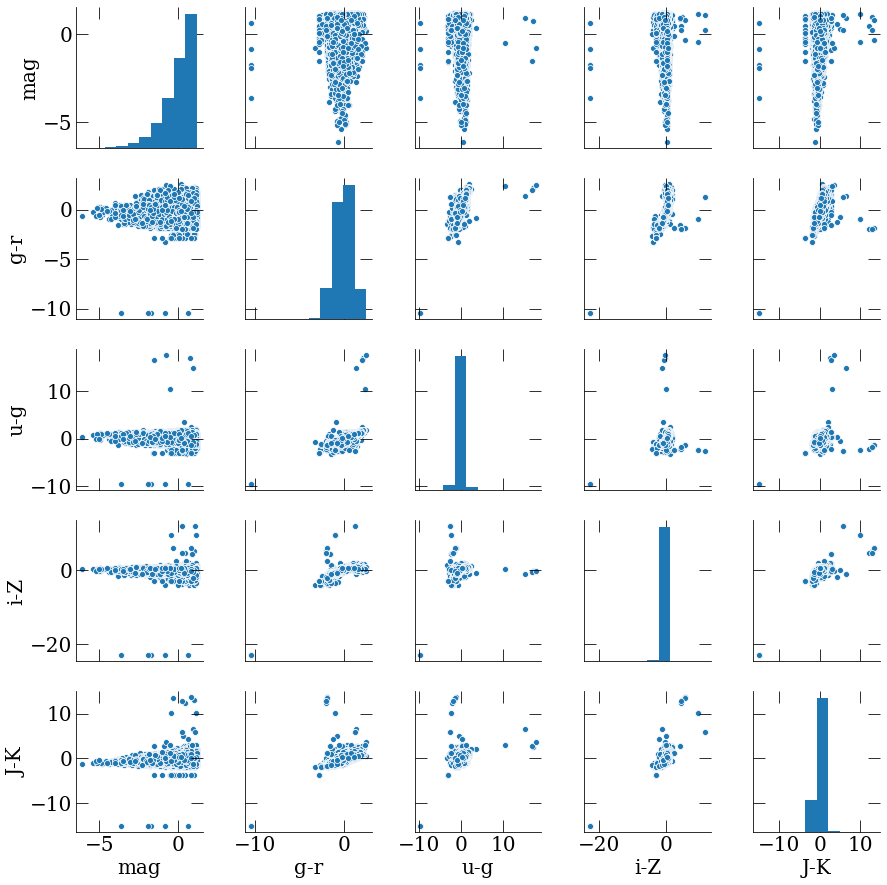

In [224]:
x = sns.pairplot(sci)

In [225]:
#training set

draws    = np.random.uniform(0, 1, len(sci))
train = (draws < 0.8)
val  = ~(draws < 0.8)

train_data = np.array(sci[train])
train_data

array([[ 0.74079076, -1.6835184 , -0.67283276, -0.7960043 , -0.94548167],
       [ 0.99772313,  0.87992057, -0.3658608 ,  0.90351793,  1.22052723],
       [-0.46091059, -0.26675495, -0.646312  , -0.22213423,  0.75601303],
       ...,
       [ 0.01145156,  1.16501566,  1.04063231,  0.55829945,  0.25178922],
       [-0.82380141,  0.47227507,  0.53900515,  0.69203981,  0.02096679],
       [ 0.1472908 , -0.13441606,  0.22365712,  0.52813159,  0.22317155]])

In [226]:
train_data.shape

(5460, 5)

In [227]:
# Initialize the SOM randomly

rand = np.random.RandomState(0)
SOM  = rand.normal(loc=0.0, scale=1.0, size=(m, n, 5)).astype(float)
SOM.shape

(10, 10, 5)

In [228]:
# update SOM

nvec, zSOM, SOM, rates, radii, lr_decay = train_SOM(SOM, train_data, nepochs=250, rand=rand)

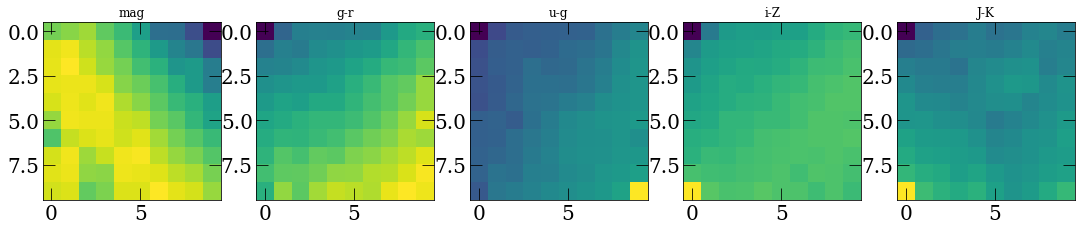

In [229]:
fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(18.5, 3.5))

for i in range(5):
    ax[i].imshow(SOM[:, :,i])

ax[0].title.set_text('mag')
ax[1].title.set_text('g-r')
ax[2].title.set_text('u-g')
ax[3].title.set_text('i-Z')
ax[4].title.set_text('J-K')

In [230]:
#create som dataframe

som_df = []

for i in range(10):
    for j in range(10):
        som_df.append(np.concatenate(( SOM[i,j], [i], [j])))

som_df = pd.DataFrame(som_df, columns=cols + ['SOM_I', 'SOM_J'])

In [231]:
sci_som = sci.append(som_df)

In [232]:
sci_som['SOM'] = 0.

In [233]:
for i in range(len(sci_som)):
    if np.isnan(sci_som.iloc[i,1])==True:
        sci_som.iloc[i,7]=1.
    else:
        sci_som.iloc[i,7]=0.

/cosma/local/Python/3.6.5/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/cosma/local/Python/3.6.5/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2
/cosma/local/Python/3.6.5/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/cosma/local/Python/3.6.5/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


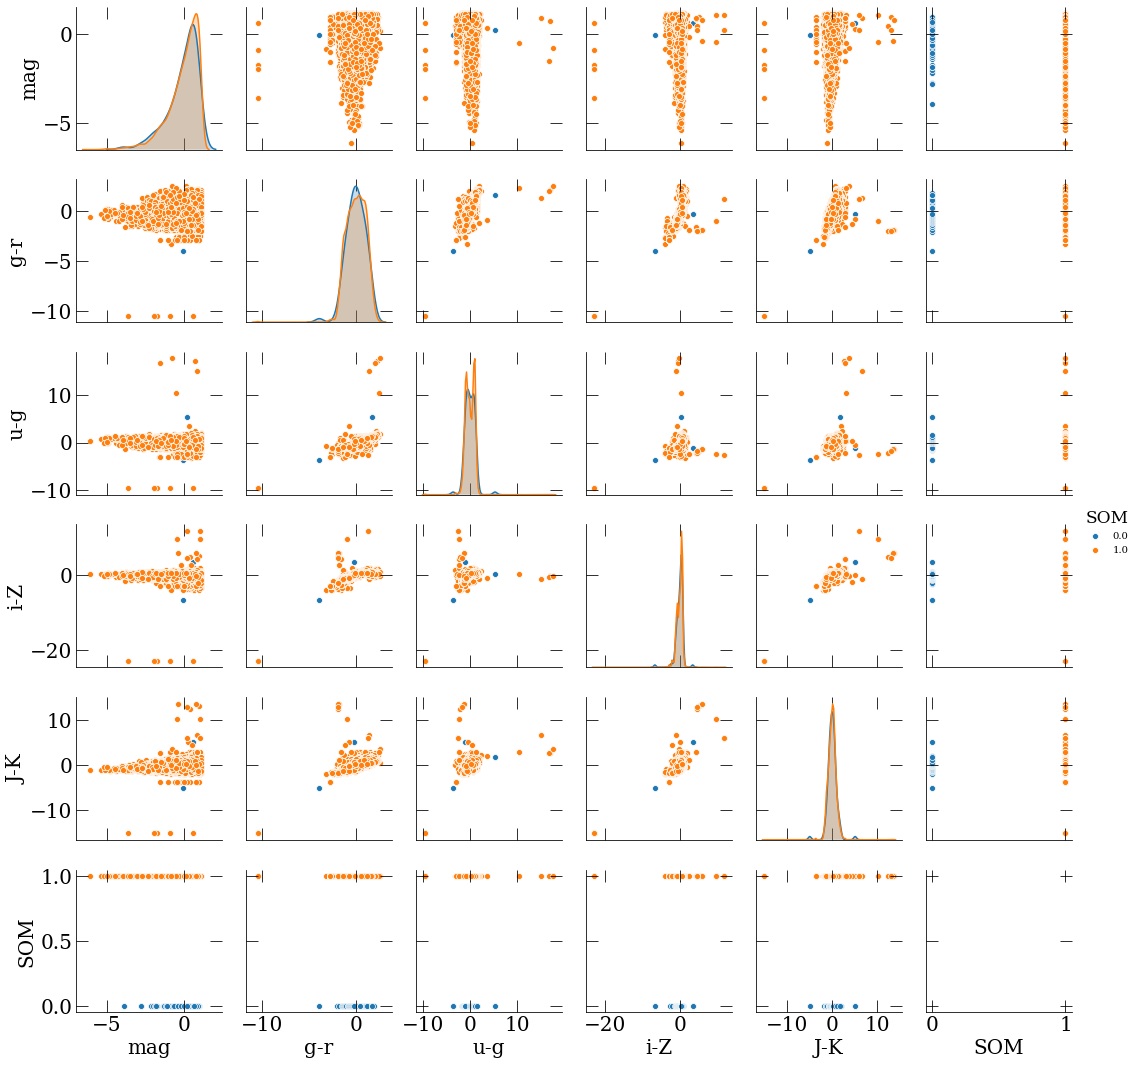

In [234]:
g = sns.pairplot(sci_som[cols+['SOM']], hue='SOM')

In [235]:
sci = Table.from_pandas(sci)

In [236]:
sci['Z_spec']=redshift_spec
sci['Z_phot']=redshift_phot
sci['uberID']=uberids

In [237]:
#find bmus for each target in catalog 

som_x = []
som_y = []

for i in range(len(sci)):
    som_x.append(find_BMU(SOM,np.array(sci[cols].to_pandas().iloc[i]))[0])
    som_y.append(find_BMU(SOM,np.array(sci[cols].to_pandas().iloc[i]))[1])

In [238]:
sci['SOM_x'] = np.array(som_x)
sci['SOM_y'] = np.array(som_y)

In [239]:
#mean redshift of each unit

mean_z = np.empty((10, 10))

for x in range(10):
    for y in range(10):
        dat = sci[train & (sci['SOM_x']==x) & (sci['SOM_y']==y)]
        mean_z[x,y]=np.mean(dat['Z_spec'].data)        

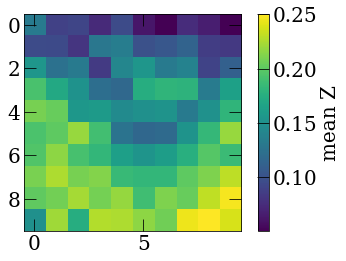

In [254]:
plt.imshow(mean_z)
c = plt.colorbar(label='mean Z')

In [241]:
val_set = sci[val]

In [249]:
"""
som_zs = []

for i in range(len(sci)):
    som_zs.append(mean_z[sci[i]['SOM_x'].data,sci[i]['SOM_y'].data])
    
sci['SOM_Z']=np.array(som_zs)

In [251]:
"""
from astropy.io import ascii
ascii.write(sci['uberID','SOM_Z'], 'sci_SOM.dat', overwrite=True)  

In [242]:
#find redshifts of validation dataset from mean som redshifts

som_zs = []

for i in range(len(val_set)):
    som_zs.append(mean_z[val_set[i]['SOM_x'].data,val_set[i]['SOM_y'].data])
    
val_set['SOM_Z']=np.array(som_zs)

(array([522., 391., 248., 134.,  74.,  24.,   9.,   5.,   2.,   2.,   0.,
          2.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.]),
 array([0.        , 0.01530612, 0.03061224, 0.04591837, 0.06122449,
        0.07653061, 0.09183673, 0.10714286, 0.12244898, 0.1377551 ,
        0.15306122, 0.16836735, 0.18367347, 0.19897959, 0.21428571,
        0.22959184, 0.24489796, 0.26020408, 0.2755102 , 0.29081633,
        0.30612245, 0.32142857, 0.33673469, 0.35204082, 0.36734694,
        0.38265306, 0.39795918, 0.41326531, 0.42857143, 0.44387755,
        0.45918367, 0.4744898 , 0.48979592, 0.50510204, 0.52040816,
        0.53571429, 0.55102041, 0.56632653, 0.58163265, 0.59693878,
        0.6122449 , 0.62755102, 0.64285714, 0.65816327, 0.67346939,
        0.68877551, 0.70408163, 0.71938776, 0.734693

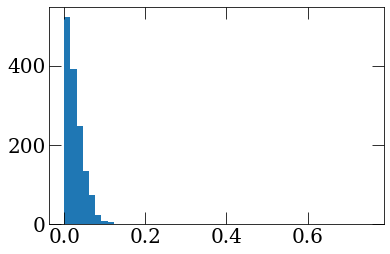

In [246]:
#residuals 

plt.hist(np.abs(val_set['Z_spec'].data-val_set['SOM_Z'].data),bins=np.linspace(0,0.75,50))

In [258]:
#compare to spectroscopic redshifts

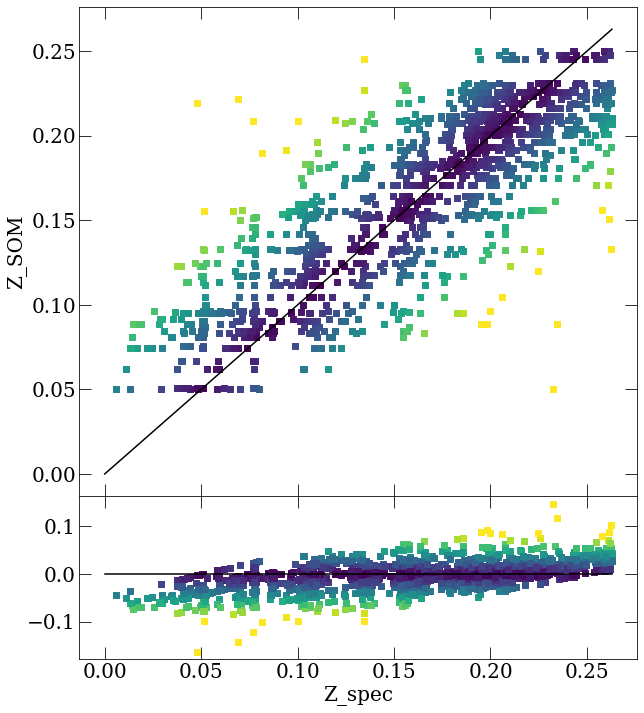

In [252]:
plt.rc('font', family='serif',size=20)
plt.rc('xtick',direction='in',labelsize=20,top=True)
plt.rc('ytick',direction='in',labelsize=20, right = True)
plt.rc('xtick.major',size = 12)
plt.rc('xtick.minor',size = 6)
plt.rc('ytick.major',size = 12)
plt.rc('ytick.minor',size = 6)
plt.rc('axes', labelsize = 20)


fig, ax = plt.subplots(2, 1, sharex=True,gridspec_kw={'height_ratios': [3, 1]},figsize=(10,12))
# Remove horizontal space between axes
fig.subplots_adjust(hspace=0)

ax[0].scatter(val_set['Z_spec'],val_set['SOM_Z'],c=np.abs(val_set['Z_spec'].data-val_set['SOM_Z'].data),vmax=0.1,marker='s')
ax[0].plot(np.linspace(0,0.263,30),np.linspace(0,0.263,30),color='black')
ax[1].set_xlabel('Z_spec')
ax[0].set_ylabel('Z_SOM')
#ax[0].set_xlim(0,0.7)
#ax[0].set_ylim(0,0.7)
ax[1].scatter(val_set['Z_spec'].data,(val_set['Z_spec'].data-val_set['SOM_Z'].data)/(1+val_set['Z_spec'].data),c=np.abs(val_set['Z_spec'].data-val_set['SOM_Z'].data),vmax=0.1,marker='s')
ax[1].plot(np.linspace(0,0.263,30),np.zeros((30)),color='black')
#ax[1].set_ylim(-0.4,0.4)
plt.savefig('som_vs_spec.png')

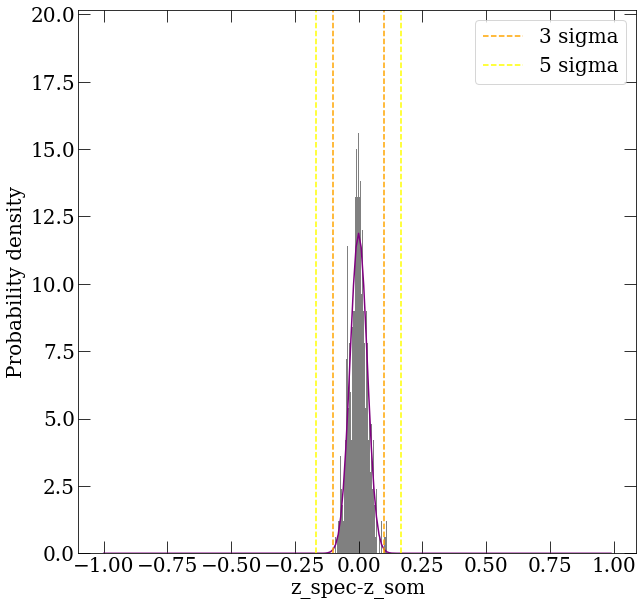

In [253]:
res = val_set['Z_spec'].data-val_set['SOM_Z'].data

plt.figure(figsize=(10,10))
plt.hist(res,bins=300,density=True,color='grey')

new_res = res[np.abs(res)<3*np.std(res)]

x =np.arange(-1,1,0.01)
plt.plot(x,norm.pdf(x,0,np.std(new_res)),color='purple')

plt.axvline(x=3*np.std(new_res), linestyle='dashed',color='orange',label='3 sigma')
plt.axvline(x=-3*np.std(new_res), linestyle='dashed',color='orange')
plt.axvline(x=5*np.std(new_res), linestyle='dashed',color='yellow',label='5 sigma')
plt.axvline(x=-5*np.std(new_res), linestyle='dashed',color='yellow')

plt.xlabel('z_spec-z_som')
plt.ylabel('Probability density')

plt.legend()

plt.savefig('som_residuals.png')

In [161]:
print('Mean: {}'.format(np.mean(res)))
print('Mean (3-sigma clipped): {}'.format(np.mean(new_res)))

Mean: -0.0006346077626964834
Mean (3-sigma clipped): -0.0005388167779602342


In [257]:
print('Std dev: {}'.format(np.std(res)))
print('Std dev (3-sigma clipped): {}'.format(np.std(new_res)))

Std dev: 0.035535721413515624
Std dev (3-sigma clipped): 0.033604997951075306


In [162]:
print('Outlier fraction greater than 3 sigma: {}'.format(len(res[np.abs(res)>3*np.std(new_res)])/len(res)))

Outlier fraction greater than 3 sigma: 0.010905125408942203


In [163]:
print('Outlier fraction greater than 5 sigma: {}'.format(len(res[np.abs(res)>5*np.std(new_res)])/len(res)))

Outlier fraction greater than 5 sigma: 0.0


In [ ]:
#compare to photometric redshifts 

(-0.15, 0.15)

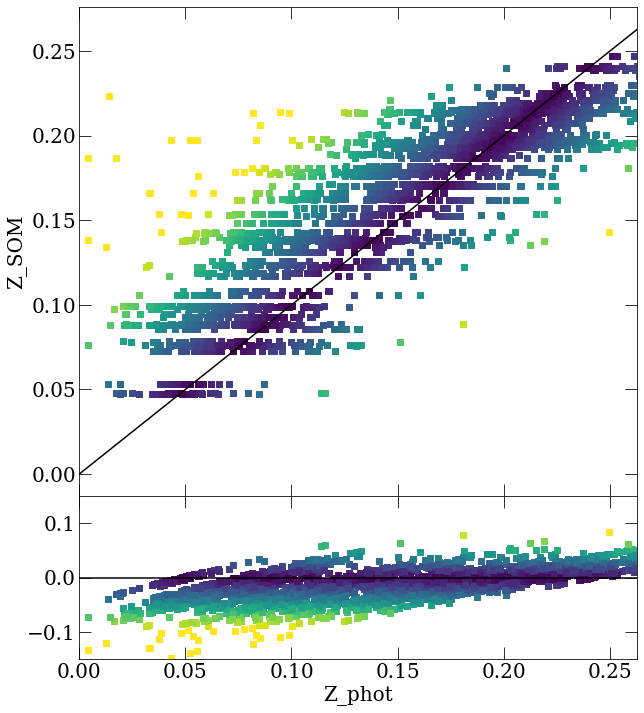

In [167]:
plt.rc('font', family='serif',size=20)
plt.rc('xtick',direction='in',labelsize=20,top=True)
plt.rc('ytick',direction='in',labelsize=20, right = True)
plt.rc('xtick.major',size = 12)
plt.rc('xtick.minor',size = 6)
plt.rc('ytick.major',size = 12)
plt.rc('ytick.minor',size = 6)
plt.rc('axes', labelsize = 20)


fig, ax = plt.subplots(2, 1, sharex=True,gridspec_kw={'height_ratios': [3, 1]},figsize=(10,12))
# Remove horizontal space between axes
fig.subplots_adjust(hspace=0)

ax[0].scatter(val_set['Z_phot'],val_set['SOM_Z'],c=np.abs(val_set['Z_phot'].data-val_set['SOM_Z'].data),vmax=0.1,marker='s')
ax[0].plot(np.linspace(0,0.263,30),np.linspace(0,0.263,30),color='black')
ax[1].set_xlabel('Z_phot')
ax[0].set_ylabel('Z_SOM')
ax[0].set_xlim(0,0.263)
#ax[0].set_ylim(0,0.7)
ax[1].scatter(val_set['Z_phot'].data,(val_set['Z_phot'].data-val_set['SOM_Z'].data)/(1+val_set['Z_phot'].data),c=np.abs(val_set['Z_phot'].data-val_set['SOM_Z'].data),vmax=0.1,marker='s')
ax[1].plot(np.linspace(0,0.263,30),np.zeros((30)),color='black')
ax[1].set_ylim(-0.15,0.15)